In [1]:
import qiskit
print(qiskit.__version__)

1.4.0


In [2]:
from mermin_benchmarking import *
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import numpy as np

from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakePrague

**Table of Contents**:
1. [Static circuits](#static-variant)
2. [Dynamic circuit](#dynamic-variant)


### 1. Static circuits <a class="anchor" id="static-variant"></a>

In [3]:
num_qubits = 3
test_mermin_static = MerminExperiment(num_qubits, mode='static')

In [4]:
terms = test_mermin_static.terms
coeffs = test_mermin_static.coeffs
mermin_state = rf'\langle {terms[0]}\rangle'
for i in range(1, len(terms)):
    mermin_state += rf""" {'-' if coeffs[i] < 0 else '+'} \langle {terms[i]} \rangle"""
state = rf"""
\[| \psi \rangle = |{'0'*num_qubits}\rangle + i |{'1'*num_qubits}\rangle 
    \implies \langle M\rangle_{{\psi}} = {mermin_state}
\]
"""   
display(Latex(state))

<IPython.core.display.Latex object>

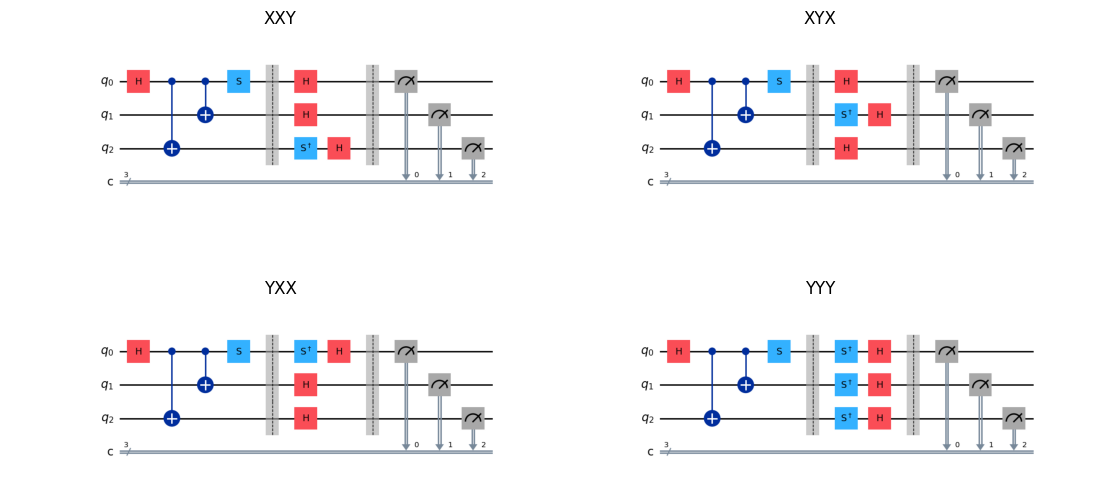

In [5]:
draw_circuits(test_mermin_static.circuits, test_mermin_static.terms)

In [6]:
num_values = 4
backend = FakePrague()
def lr_exp(num_qubits):
    if num_qubits % 2 == 0:
        return 2**(num_qubits/2)
    else:
        return 2**((num_qubits-1)/2)

def qm_exp(num_qubits):
    return 2**(num_qubits-1)

noise_tests = [MerminExperiment(num, backend=backend, error_mitigation=False) for num in range(2, 2 + num_values)]
mnoise_tests = [MerminExperiment(num, backend=backend, error_mitigation=True) for num in range(2, 2 + num_values)]
sv_tests = [MerminExperiment(num) for num in range(2, 2 + num_values)]
qm_values = [qm_exp(num) for num in range(2, 2 + num_values)]
lr_values = [lr_exp(num)/qm_exp(num) for num in range(2, 2 + num_values)]

noise_values = [noise_tests[i].run()/qm_exp(2+i) for i in range(len(noise_tests))]
mnoise_values = [mnoise_tests[i].run()/qm_exp(2+i) for i in range(len(mnoise_tests))]
sv_values =  [sv_tests[i].run()/qm_exp(2+i) for i in range(len(sv_tests))]

# Noisy run without GHZ optimization nor error mitigation
unoptimized_circuits = [mermin_circuits(mermin_terms(num)[0]) for num in range(2, 2 + num_values)]
unoptimized_values = [run_static(unoptimized_circuits[num - 2], shots=1024, backend=backend)/qm_exp(num) for num in range(2, 2+ num_values)]

In [7]:
d_noise_values = [noise_tests[i].metrics['average_depth'] for i in range(len(noise_tests))]
#d_mnoise_values = [mnoise_tests[i].metrics['average_depth'] for i in range(len(mnoise_tests))]
cx_noise_values = [noise_tests[i].metrics['average_two_qubit_gates'] for i in range(len(noise_tests))]
#cx_mnoise_values = [mnoise_tests[i].metrics['average_two_qubit_gates'] for i in range(len(mnoise_tests))]

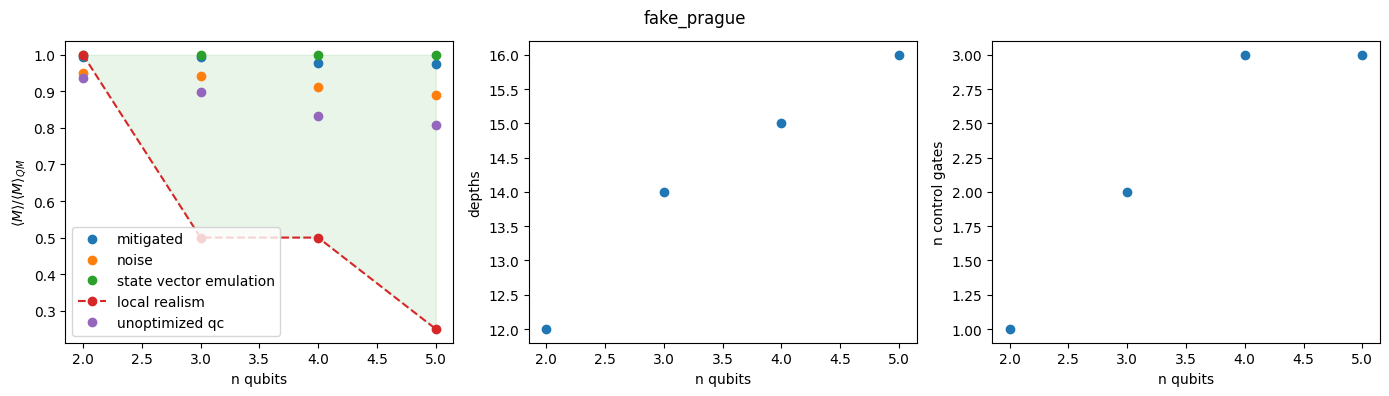

In [8]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(np.arange(2, 2 + num_values), mnoise_values, 'o', label='mitigated')
plt.plot(np.arange(2, 2 + num_values), noise_values, 'o', label='noise')
plt.plot(np.arange(2, 2 + num_values), sv_values, 'o', label='state vector emulation')
#plt.plot(np.arange(2,2 + num_valuesn), m_noiseless, 'o', label='noiseless')
plt.plot(np.arange(2, 2 + num_values), lr_values, 'o--', label='local realism')
#plt.plot(np.arange(2, 2 + num_values), qm_values, 'o--', label='qm')
plt.plot(np.arange(2, 2 + num_values), unoptimized_values, 'o', label='unoptimized qc')


plt.fill_between(np.arange(2, 2 +num_values), lr_values, sv_values, color='C2', alpha=0.1)
plt.xlabel('n qubits')
plt.ylabel('$\\langle M\\rangle / \\langle M\\rangle_{QM}$')
plt.legend()

plt.subplot(1, 3, 2)
#plt.plot(np.arange(2, 2 + num_values), d_mnoise_values, 'o', label='mitigated')
plt.plot(np.arange(2, 2 + num_values), d_noise_values, 'o', label='noise')

plt.xlabel('n qubits')
plt.ylabel('depths')
#plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.arange(2, 2 + num_values), cx_noise_values, 'o', label='mitigated')
#plt.plot(np.arange(2, 2 + num_values), cx_mnoise_values, 'o', label='noise')

plt.xlabel('n qubits')
plt.ylabel('n control gates')
#plt.legend()

plt.tight_layout()
plt.suptitle(f'{backend.name}')
plt.subplots_adjust(top=0.90)
plt.show()

### 2. Dynamic circuit <a class="anchor" id="dynamic-variant"></a>

In [9]:
from qiskit.circuit.controlflow import IfElseOp
backend = FakePrague()

backend.target.add_instruction(IfElseOp, name='if_else')

In [10]:
num_values = 3

noise_tests = [MerminExperiment(num, backend=backend, mode='dynamic', error_mitigation=False) for num in range(2, 2 + num_values)]
mnoise_tests = [MerminExperiment(num, backend=backend, mode='dynamic', error_mitigation=True) for num in range(2, 2 + num_values)]
sv_tests = [MerminExperiment(num, mode='dynamic') for num in range(2, 2 + num_values)]

In [11]:
qm_values = [qm_exp(num) for num in range(2, 2 + num_values)]
lr_values = [lr_exp(num)/qm_exp(num) for num in range(2, 2 + num_values)]

In [12]:
noise_values = [noise_tests[i].run()/qm_exp(2+i) for i in range(len(noise_tests))]
mnoise_values = [mnoise_tests[i].run()/qm_exp(2+i) for i in range(len(mnoise_tests))]
sv_values =  [sv_tests[i].run()/qm_exp(2+i) for i in range(len(sv_tests))]

unoptimized_circuits = [mermin_aspect_circuit(num) for num in range(2, 2 + num_values)]
unoptimized_values = [run_dynamic(unoptimized_circuits[num - 2], shots=1024, backend=backend)/qm_exp(num) for num in range(2, 2+ num_values)]

In [13]:
d_noise_values = [noise_tests[i].metrics['average_depth'] for i in range(len(noise_tests))]
#d_mnoise_values = [mnoise_tests[i].metrics['average_depth'] for i in range(len(mnoise_tests))]
cx_noise_values = [noise_tests[i].metrics['average_two_qubit_gates'] for i in range(len(noise_tests))]
#cx_mnoise_values = [mnoise_tests[i].metrics['average_two_qubit_gates'] for i in range(len(mnoise_tests))]

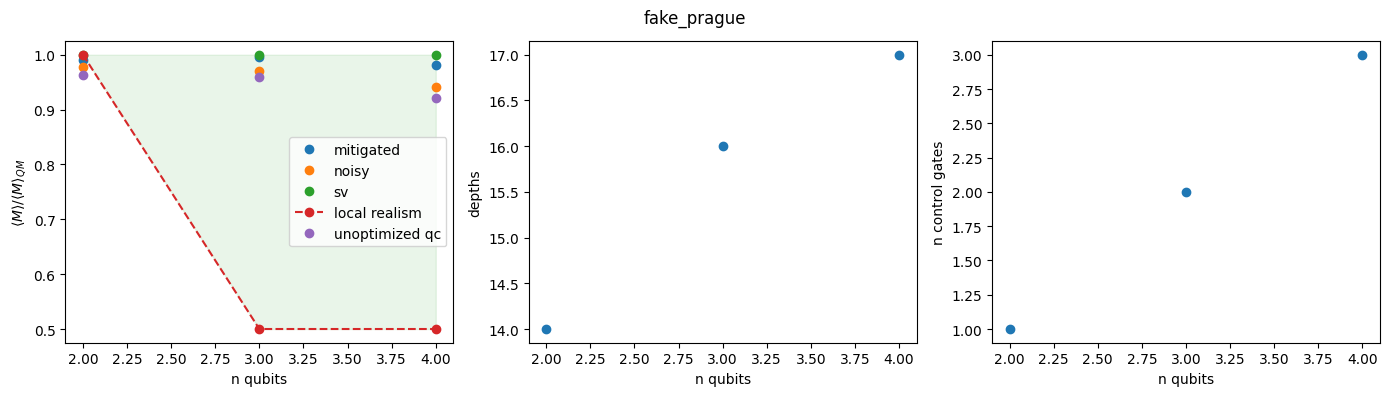

In [14]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(np.arange(2, 2 + num_values), mnoise_values, 'o', label='mitigated')
plt.plot(np.arange(2, 2 + num_values), noise_values, 'o', label='noisy')
plt.plot(np.arange(2, 2 + num_values), sv_values, 'o', label='sv')
#plt.plot(np.arange(2,2 + num_valuesn), m_noiseless, 'o', label='noiseless')
plt.plot(np.arange(2, 2 + num_values), lr_values, 'o--', label='local realism')
#plt.plot(np.arange(2, 2 + num_values), qm_values, 'o--', label='qm')
plt.plot(np.arange(2, 2 + num_values), unoptimized_values, 'o', label='unoptimized qc')

plt.fill_between(np.arange(2, 2 +num_values), lr_values, sv_values, color='C2', alpha=0.1)
plt.xlabel('n qubits')
plt.ylabel('$\\langle M\\rangle / \\langle M\\rangle_{QM}$')
plt.legend()

plt.subplot(1, 3, 2)
#plt.plot(np.arange(2, 2 + num_values), d_mnoise_values, 'o', label='mitigated')
plt.plot(np.arange(2, 2 + num_values), d_noise_values, 'o', label='noise')

plt.xlabel('n qubits')
plt.ylabel('depths')

plt.subplot(1, 3, 3)
plt.plot(np.arange(2, 2 + num_values), cx_noise_values, 'o', label='mitigated')
#plt.plot(np.arange(2, 2 + num_values), cx_mnoise_values, 'o', label='noise')

plt.xlabel('n qubits')
plt.ylabel('n control gates')

plt.tight_layout()
plt.suptitle(f'{backend.name}')
plt.subplots_adjust(top=0.90)
plt.show()